In [1]:
import torch
import lightning as L
import numpy as np
import matplotlib.pyplot as plt

from src.jepa import JEPA
from src.data.dataset import PointMazeTransitions


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
dataset = PointMazeTransitions("data/train_trajectories_small.npz", frame_size=(96, 96))

[Dataset] Frames resized to 96×96
[Dataset] Loaded 10 episodes, 1000 transitions.
[Dataset] Frame shape: (96, 96, 3)


In [3]:
jepa = JEPA.load_from_checkpoint("checkpoints/jepa/JEPA-172-0.0043.ckpt")
jepa.to(device)
jepa.eval();

In [4]:
(state, frame), action, (next_state, next_frame) = dataset[0]

In [5]:
actions = torch.stack([dataset[i][1] for i in range(100)])
true_frames = torch.stack([dataset[i][0][1] for i in range(100)])

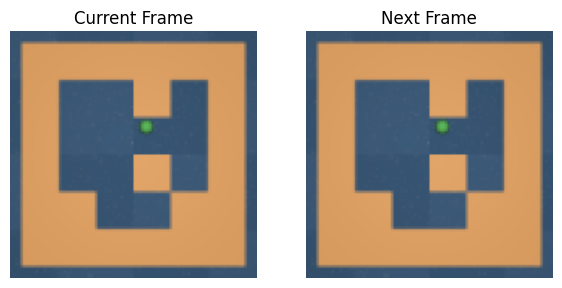

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(7, 4))
axs[0].imshow(frame.permute(1, 2, 0).numpy())
axs[0].set_title("Current Frame")
axs[1].imshow(next_frame.permute(1, 2, 0).numpy())
axs[1].set_title("Next Frame")
axs[0].axis('off')
axs[1].axis('off')
plt.show()

In [7]:
# Encode current frame
with torch.no_grad():
    z_state, z_action, z_next_state = jepa.encode(
        state.to(device).unsqueeze(0),
        frame.to(device).unsqueeze(0),
        action.to(device).unsqueeze(0),
        next_state.to(device).unsqueeze(0),
        next_frame.to(device).unsqueeze(0)
    )
    z_frame = jepa.encoder_teacher(frame.to(device).unsqueeze(0))
    z_frame_next = jepa.encoder_teacher(next_frame.to(device).unsqueeze(0))
    # Predict next state representation
    z_next_state_pred = jepa.predict_next(z_state, z_action)
    # Decode current, next and and predicted next frame
    frame_recon = jepa.decoder(z_state)
    next_frame_recon = jepa.decoder(z_next_state_pred)

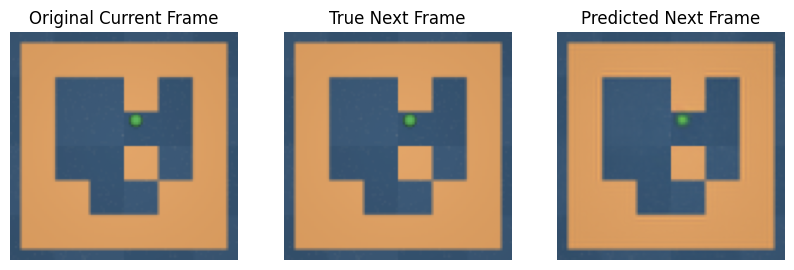

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4))
axs[0].imshow(frame.permute(1, 2, 0).numpy())
axs[0].set_title("Original Current Frame")
axs[1].imshow(next_frame.permute(1, 2, 0).numpy())
axs[1].set_title("True Next Frame")
axs[2].imshow(next_frame_recon.squeeze(0).permute(1, 2, 0).cpu().numpy())
axs[2].set_title("Predicted Next Frame")
axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
plt.show()

In [9]:
@torch.no_grad()
def predict_future(jepa, state, frame, actions, k, device="cuda"):
    jepa.to(device)
    jepa.eval()
    frames_pred = []

    z_state = jepa.proprio_encoder(state.to(device))
    z_frame = jepa.encoder_teacher(frame.to(device))
    z = torch.cat([z_state, z_frame], dim=1)
    z_actions = jepa.action_encoder(actions.to(device))

    for t in range(k):
        # predict next state
        z_next = jepa.predict_next(z.to(device), z_actions[t, :].unsqueeze(0).to(device))

        # decode predicted next frame
        frame_pred = jepa.decoder(z_next)

        frames_pred.append(frame_pred.squeeze(0).cpu())
        z = z_next
    
    return frames_pred


In [10]:
frames = predict_future(
    jepa=jepa,
    state=state.unsqueeze(0),
    frame=frame.unsqueeze(0),
    actions=actions,  # shape (B, k, action_dim)
    k=100,
    device=device
)
frames = torch.stack(frames)  # shape (k, C, H, W)

In [11]:
# Create video of predicted frames
import imageio
video_frames = []
for t in range(frames.shape[0]):
    img = frames[t].permute(1, 2, 0).numpy()
    video_frames.append((img * 255).astype(np.uint8))
imageio.mimwrite('predicted_future.gif', video_frames, fps=5)
print("Saved predicted future video as 'predicted_future.gif'")
# Create video of true frames
true_video_frames = []
for t in range(true_frames.shape[0]):
    img = true_frames[t].permute(1, 2, 0).numpy()
    true_video_frames.append((img * 255).astype(np.uint8))
imageio.mimwrite('true_future.gif', true_video_frames, fps=5)
print("Saved true future video as 'true_future.gif'")

Saved predicted future video as 'predicted_future.gif'
Saved true future video as 'true_future.gif'


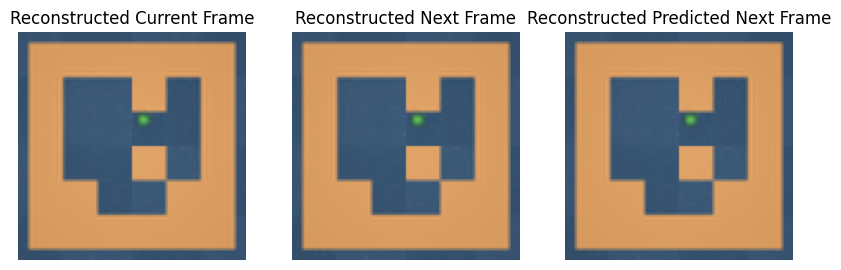

In [12]:
# plot
fig, axs = plt.subplots(1, 3, figsize=(10, 4))
axs[0].imshow(frame_recon.squeeze(0).permute(1, 2, 0).cpu().numpy())
axs[0].set_title("Reconstructed Current Frame")
axs[1].imshow(next_frame_recon.squeeze(0).permute(1, 2, 0).cpu().numpy())
axs[1].set_title("Reconstructed Next Frame")
axs[2].imshow(frame_recon.squeeze(0).permute(1, 2, 0).cpu().numpy())
axs[2].set_title("Reconstructed Predicted Next Frame")
axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
plt.show()